# Bookmakers' Odds Analysis

In [10]:
import sqlite3

import pandas as pd
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import log_loss, roc_auc_score

The test set for our model will consist of fights that occurred between 2022 and 2024 (up to when the dataset was created) in which both fighters had at least 1 fight in the UFC, so we will analyze the bookmakers' performance for these same fights to get some points of comparison. Since draws and no contests void the bets, we will only consider fights that had a winner.

NOTE: For backtesting later, we *will* consider fights that ended in draws and no contests as well to simulate voided bets.

### Obtain Market-Implied Probabilities

In [11]:
conn = sqlite3.connect("../data/ufcstats.db")
conn.execute("ATTACH DATABASE '../data/fightoddsio.db' AS fightoddsio")

df = pd.read_sql(
    """
    WITH bout_num_by_fighter AS (
      SELECT 
        *, 
        ROW_NUMBER() OVER(
          PARTITION BY FIGHTER_ID 
          ORDER BY 
            DATE, 
            EVENT_ID, 
            BOUT_ORDINAL
        ) AS BOUT_NUMBER 
      FROM 
        (
          SELECT 
            BOUT_ID, 
            EVENT_ID, 
            DATE, 
            BOUT_ORDINAL, 
            RED_FIGHTER_ID AS FIGHTER_ID 
          FROM 
            main.UFCSTATS_BOUTS_OVERALL 
          UNION ALL 
          SELECT 
            BOUT_ID, 
            EVENT_ID, 
            DATE, 
            BOUT_ORDINAL, 
            BLUE_FIGHTER_ID AS FIGHTER_ID 
          FROM 
            main.UFCSTATS_BOUTS_OVERALL
        ) 
      ORDER BY 
        DATE, 
        EVENT_ID, 
        BOUT_ORDINAL
    ), 
    bouts_test AS (
      SELECT 
        t1.BOUT_ID, 
        t1.EVENT_ID, 
        t1.RED_FIGHTER_ID, 
        t1.BLUE_FIGHTER_ID, 
        t1.BOUT_ORDINAL, 
        t1.DATE, 
        CASE t1.RED_OUTCOME WHEN 'W' THEN 1 WHEN 'L' THEN 0 ELSE NULL END AS RED_WIN 
      FROM 
        main.UFCSTATS_BOUTS_OVERALL AS t1 
        LEFT JOIN bout_num_by_fighter AS t2 ON t1.RED_FIGHTER_ID = t2.FIGHTER_ID 
        AND t1.BOUT_ID = t2.BOUT_ID 
        LEFT JOIN bout_num_by_fighter AS t3 ON t1.BLUE_FIGHTER_ID = t3.FIGHTER_ID 
        AND t1.BOUT_ID = t3.BOUT_ID 
      WHERE 
        t2.BOUT_NUMBER > 1 
        AND t3.BOUT_NUMBER > 1 
        AND t1.DATE >= '2022-01-01' 
        AND RED_WIN IS NOT NULL 
      ORDER BY 
        t1.DATE, 
        t1.BOUT_ORDINAL
    ) 
    SELECT 
      t1.BOUT_ID, 
      t1.DATE, 
      t1.EVENT_ID, 
      t1.BOUT_ORDINAL, 
      t5.FIGHTER_1_ODDS AS RED_FIGHTER_ODDS, 
      t5.FIGHTER_2_ODDS AS BLUE_FIGHTER_ODDS, 
      t1.RED_WIN 
    FROM 
      bouts_test AS t1 
      INNER JOIN fightoddsio.FIGHTODDSIO_EVENT_LINKAGE AS t2 ON t1.EVENT_ID = t2.UFCSTATS_EVENT_ID 
      INNER JOIN fightoddsio.FIGHTODDSIO_FIGHTER_LINKAGE AS t3 ON t1.RED_FIGHTER_ID = t3.UFCSTATS_FIGHTER_ID 
      INNER JOIN fightoddsio.FIGHTODDSIO_FIGHTER_LINKAGE AS t4 ON t1.BLUE_FIGHTER_ID = t4.UFCSTATS_FIGHTER_ID 
      INNER JOIN fightoddsio.FIGHTODDSIO_BOUTS AS t5 ON t2.FIGHTODDSIO_EVENT_SLUG = t5.EVENT_SLUG 
      AND t3.FIGHTODDSIO_FIGHTER_ID = t5.FIGHTER_1_ID 
      AND t4.FIGHTODDSIO_FIGHTER_ID = t5.FIGHTER_2_ID 
    UNION ALL 
    SELECT 
      t1.BOUT_ID, 
      t1.DATE, 
      t1.EVENT_ID, 
      t1.BOUT_ORDINAL, 
      t5.FIGHTER_2_ODDS AS RED_FIGHTER_ODDS, 
      t5.FIGHTER_1_ODDS AS BLUE_FIGHTER_ODDS, 
      t1.RED_WIN 
    FROM 
      bouts_test AS t1 
      INNER JOIN fightoddsio.FIGHTODDSIO_EVENT_LINKAGE AS t2 ON t1.EVENT_ID = t2.UFCSTATS_EVENT_ID 
      INNER JOIN fightoddsio.FIGHTODDSIO_FIGHTER_LINKAGE AS t3 ON t1.RED_FIGHTER_ID = t3.UFCSTATS_FIGHTER_ID 
      INNER JOIN fightoddsio.FIGHTODDSIO_FIGHTER_LINKAGE AS t4 ON t1.BLUE_FIGHTER_ID = t4.UFCSTATS_FIGHTER_ID 
      INNER JOIN fightoddsio.FIGHTODDSIO_BOUTS AS t5 ON t2.FIGHTODDSIO_EVENT_SLUG = t5.EVENT_SLUG 
      AND t3.FIGHTODDSIO_FIGHTER_ID = t5.FIGHTER_2_ID 
      AND t4.FIGHTODDSIO_FIGHTER_ID = t5.FIGHTER_1_ID 
    ORDER BY 
      t1.DATE, 
      t1.EVENT_ID, 
      t1.BOUT_ORDINAL;
    """,
    conn,
)[["BOUT_ID", "DATE", "RED_FIGHTER_ODDS", "BLUE_FIGHTER_ODDS", "RED_WIN"]]

conn.close()

In [12]:
df.head()

,BOUT_ID,DATE,RED_FIGHTER_ODDS,BLUE_FIGHTER_ODDS,RED_WIN
0,3a8c0158d910546d,2022-01-15,1.469937,2.743333,1
1,7c2a02b5ea169b54,2022-01-15,1.261991,3.975000,1
2,3738135e4c9d8273,2022-01-15,2.028730,1.796695,1
3,f9a4e625dffc30d4,2022-01-15,1.462680,2.793333,1
4,8d89f3b8798f444d,2022-01-15,1.629805,2.316667,1


We will compute the market implied probabilities for each fight by converting the average decimal odds to probabilities and removing the bookmakers' margin.

In [13]:
# Convert decimal odds to probability
df2 = df.copy()
df2["RED_PROB_VIG"] = 1 / df2["RED_FIGHTER_ODDS"]
df2["BLUE_PROB_VIG"] = 1 / df2["BLUE_FIGHTER_ODDS"]

# Calculate implied probability
df2["RED_PROB_IMPLIED"] = df2["RED_PROB_VIG"] / (
    df2["RED_PROB_VIG"] + df2["BLUE_PROB_VIG"]
)

df2 = df2[["BOUT_ID", "RED_PROB_IMPLIED", "RED_WIN"]]
df2.head()

,BOUT_ID,RED_PROB_IMPLIED,RED_WIN
0,3a8c0158d910546d,0.651117,1
1,7c2a02b5ea169b54,0.759024,1
2,3738135e4c9d8273,0.469672,1
3,f9a4e625dffc30d4,0.656326,1
4,8d89f3b8798f444d,0.587022,1


### Evaluate Bookmakers' Performance

In [14]:
# Calculate log loss
log_loss(df2["RED_WIN"], df2["RED_PROB_IMPLIED"])

0.610120393077667

In [15]:
# Calculate AUC
roc_auc_score(df2["RED_WIN"], df2["RED_PROB_IMPLIED"])

0.7183800942043825

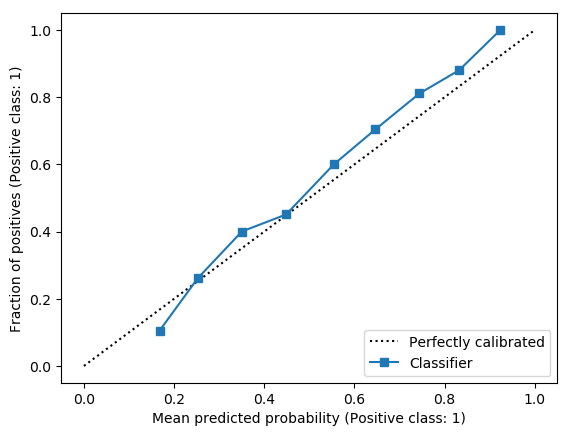

In [16]:
# Calibration curve
disp = CalibrationDisplay.from_predictions(
    df2["RED_WIN"], df2["RED_PROB_IMPLIED"], n_bins=10
)

In general, the betting market is extremely efficient based on the closing odds; moreover, the decimal odds in the data above correspond to an averaging across multiple bookmakers, so we expect the implied probabilities to be even more accurate than any single bookmaker's odds. As such, these numbers represent an unattainable ideal for our model to strive for. However, if one were to bet much earlier than the closing odds, there may be some value to be found.